In [1]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import array, sqrt
from numpy.random import randn
from filterpy.stats import plot_covariance_ellipse
from sympy import symbols, Matrix, sin, cos, tan, atan2

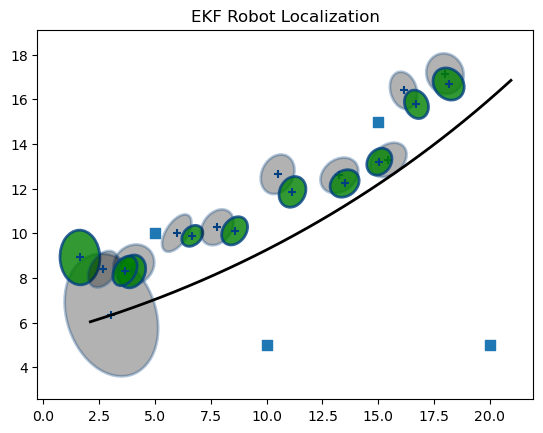

Final P: [0.01537735 0.01569074 0.00160824]


In [2]:
# Define the EKF class for the robot
class RobotEKF(EKF):
    def __init__(self, dt, wheelbase, std_vel, std_steer):
        EKF.__init__(self, 3, 2, 2)
        self.dt = dt
        self.wheelbase = wheelbase
        self.std_vel = std_vel
        self.std_steer = std_steer

        # Define symbolic variables
        a, x, y, v, w, theta, time = symbols('a x y v w theta t')
        d = v * time
        beta = (d / w) * tan(a)
        r = w / tan(a)

        self.fxu = Matrix([
            [x - r * sin(theta) + r * sin(theta + beta)],
            [y + r * cos(theta) - r * cos(theta + beta)],
            [theta + beta]
        ])

        self.F_j = self.fxu.jacobian(Matrix([x, y, theta]))
        self.V_j = self.fxu.jacobian(Matrix([v, a]))

        self.subs = {x: 0, y: 0, v: 0, a: 0, time: dt, w: wheelbase, theta: 0}
        self.x_x, self.x_y = x, y
        self.v, self.a, self.theta = v, a, theta

    def predict(self, u):
        self.x = self.move(self.x, u, self.dt)
        self.subs[self.x_x] = self.x[0, 0]
        self.subs[self.x_y] = self.x[1, 0]
        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.a] = u[1]

        F = np.array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = np.array(self.V_j.evalf(subs=self.subs)).astype(float)

        M = np.array([[self.std_vel**2, 0], [0, self.std_steer**2]])

        self.P = F @ self.P @ F.T + V @ M @ V.T

    def move(self, x, u, dt):
        hdg = x[2, 0]
        vel = u[0]
        steering_angle = u[1]
        dist = vel * dt

        if abs(steering_angle) > 0.001:
            beta = (dist / self.wheelbase) * np.tan(steering_angle)
            r = self.wheelbase / np.tan(steering_angle)

            dx = np.array([
                [-r * np.sin(hdg) + r * np.sin(hdg + beta)], 
                [r * np.cos(hdg) - r * np.cos(hdg + beta)], 
                [beta]
            ])
        else:
            dx = np.array([
                [dist * np.cos(hdg)], 
                [dist * np.sin(hdg)], 
                [0]
            ])
        return x + dx

# Residual function for angle normalization
def residual(a, b):
    y = a - b
    y[1] = y[1] % (2 * np.pi)
    if np.any(y[1] > np.pi):
        y[1] -= 2 * np.pi
    return y

# Define Jacobian of measurement model
def jacobian_measurement_model(x, landmark_pos):
    px = landmark_pos[0]
    py = landmark_pos[1]
    hyp = (px - x[0, 0])**2 + (py - x[1, 0])**2
    dist = np.sqrt(hyp)

    H = np.array([
        [-(px - x[0, 0]) / dist, -(py - x[1, 0]) / dist, 0],
        [(py - x[1, 0]) / hyp, -(px - x[0, 0]) / hyp, -1]
    ])
    return H

# Define measurement model function
def measurement_model(x, landmark_pos):
    px = landmark_pos[0]
    py = landmark_pos[1]
    dist = np.sqrt((px - x[0, 0])**2 + (py - x[1, 0])**2)
    return np.array([[dist], [np.arctan2(py - x[1, 0], px - x[0, 0]) - x[2, 0]]])

# Run the EKF for robot localization
def run_ekf_localization(landmarks, std_vel, std_steer, std_range, std_bearing, step=10, ellipse_step=20):
    ekf = RobotEKF(dt=1.0, wheelbase=0.5, std_vel=std_vel, std_steer=std_steer)
    ekf.x = np.array([[2, 6, 0.3]]).T
    ekf.P = np.diag([0.1, 0.1, 0.1])
    ekf.R = np.diag([std_range**2, std_bearing**2])

    sim_pos = ekf.x.copy()
    u = np.array([1.1, 0.01])

    plt.figure()
    plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='s', s=60)

    track = []
    for i in range(200):
        sim_pos = ekf.move(sim_pos, u, dt=0.1)
        track.append(sim_pos)

        if i % step == 0:
            ekf.predict(u=u)

            if i % ellipse_step == 0:
                plot_covariance_ellipse((ekf.x[0, 0], ekf.x[1, 0]), ekf.P[0:2, 0:2], std=6, facecolor='k', alpha=0.3)

            for lmark in landmarks:
                z = measurement_model(sim_pos, lmark) + np.random.randn(2) * [std_range, std_bearing]
                ekf.update(z, HJacobian=jacobian_measurement_model, Hx=measurement_model, residual=residual, args=(lmark,), hx_args=(lmark,))

            if i % ellipse_step == 0:
                plot_covariance_ellipse((ekf.x[0, 0], ekf.x[1, 0]), ekf.P[0:2, 0:2], std=6, facecolor='g', alpha=0.8)

    track = np.array(track)
    plt.plot(track[:, 0], track[:, 1], color='k', lw=2)
    plt.axis('equal')
    plt.title("EKF Robot Localization")
    plt.show()
    return ekf

# Landmarks for simulation
landmarks = np.array([[5, 10], [10, 5], [15, 15], [20, 5]])

# Run the EKF with the defined landmarks
ekf = run_ekf_localization(landmarks, std_vel=0.1, std_steer=np.radians(1), std_range=0.3, std_bearing=0.1)
print('Final P:', ekf.P.diagonal())

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import array, sqrt
from numpy.random import randn
from filterpy.stats import plot_covariance_ellipse
from sympy import symbols, Matrix, sin, cos, tan, atan2

# Define the EKF class for the robot
class RobotEKF(EKF):
    def __init__(self, dt, wheelbase, std_vel, std_steer):
        EKF.__init__(self, 3, 2, 2)
        self.dt = dt
        self.wheelbase = wheelbase
        self.std_vel = std_vel
        self.std_steer = std_steer

        # Define symbolic variables
        a, x, y, v, w, theta, time = symbols('a x y v w theta t')
        d = v * time
        beta = (d / w) * tan(a)
        r = w / tan(a)

        self.fxu = Matrix([
            [x - r * sin(theta) + r * sin(theta + beta)],
            [y + r * cos(theta) - r * cos(theta + beta)],
            [theta + beta]
        ])

        self.F_j = self.fxu.jacobian(Matrix([x, y, theta]))
        self.V_j = self.fxu.jacobian(Matrix([v, a]))

        self.subs = {x: 0, y: 0, v: 0, a: 0, time: dt, w: wheelbase, theta: 0}
        self.x_x, self.x_y = x, y
        self.v, self.a, self.theta = v, a, theta

    def predict(self, u):
        self.x = self.move(self.x, u, self.dt)
        self.subs[self.x_x] = self.x[0, 0]
        self.subs[self.x_y] = self.x[1, 0]
        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.a] = u[1]

        F = np.array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = np.array(self.V_j.evalf(subs=self.subs)).astype(float)

        M = np.array([[self.std_vel**2, 0], [0, self.std_steer**2]])

        self.P = F @ self.P @ F.T + V @ M @ V.T

    def move(self, x, u, dt):
        hdg = x[2, 0]
        vel = u[0]
        steering_angle = u[1]
        dist = vel * dt

        if abs(steering_angle) > 0.001:
            beta = (dist / self.wheelbase) * np.tan(steering_angle)
            r = self.wheelbase / np.tan(steering_angle)

            dx = np.array([
                [-r * np.sin(hdg) + r * np.sin(hdg + beta)], 
                [r * np.cos(hdg) - r * np.cos(hdg + beta)], 
                [beta]
            ])
        else:
            dx = np.array([
                [dist * np.cos(hdg)], 
                [dist * np.sin(hdg)], 
                [0]
            ])
        return x + dx

In [5]:
# Residual function for angle normalization
def residual(a, b):
    y = a - b
    y[1] = y[1] % (2 * np.pi)
    if np.any(y[1] > np.pi):
        y[1] -= 2 * np.pi
    return y

In [6]:
# Define Jacobian of measurement model
def jacobian_measurement_model(x, landmark_pos):
    px = landmark_pos[0]
    py = landmark_pos[1]
    hyp = (px - x[0, 0])**2 + (py - x[1, 0])**2
    dist = np.sqrt(hyp)

    H = np.array([
        [-(px - x[0, 0]) / dist, -(py - x[1, 0]) / dist, 0],
        [(py - x[1, 0]) / hyp, -(px - x[0, 0]) / hyp, -1]
    ])
    return H

In [11]:
# Define measurement model function
def measurement_model(x, landmark_pos):
    px = landmark_pos[0]
    py = landmark_pos[1]
    dist = np.sqrt((px - x[0, 0])**2 + (py - x[1, 0])**2)
    return np.array([[dist], [np.arctan2(py - x[1, 0], px - x[0, 0]) - x[2, 0]]])

In [13]:
# Run the EKF for robot localization
def run_ekf_localization(landmarks, std_vel, std_steer, std_range, std_bearing, step=10, ellipse_step=20):
    ekf = RobotEKF(dt=1.0, wheelbase=0.5, std_vel=std_vel, std_steer=std_steer)
    ekf.x = np.array([[2, 6, 0.3]]).T
    ekf.P = np.diag([0.1, 0.1, 0.1])
    ekf.R = np.diag([std_range**2, std_bearing**2])

    sim_pos = ekf.x.copy()
    u = np.array([1.1, 0.01])

    plt.figure()
    plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='s', s=60, label='Landmarks')

    track = []
    for i in range(200):
        sim_pos = ekf.move(sim_pos, u, dt=0.1)
        track.append(sim_pos)

        if i % step == 0:
            ekf.predict(u=u)

            if i % ellipse_step == 0:
                plot_covariance_ellipse((ekf.x[0, 0], ekf.x[1, 0]), ekf.P[0:2, 0:2], std=6, facecolor='k', alpha=0.3)

            for lmark in landmarks:
                z = measurement_model(sim_pos, lmark) + np.random.randn(2) * [std_range, std_bearing]
                ekf.update(z, HJacobian=jacobian_measurement_model, Hx=measurement_model, residual=residual, args=(lmark,), hx_args=(lmark,))

            if i % ellipse_step == 0:
                plot_covariance_ellipse((ekf.x[0, 0], ekf.x[1, 0]), ekf.P[0:2, 0:2], std=6, facecolor='g', alpha=0.8)

    track = np.array(track)
    plt.plot(track[:, 0], track[:, 1], color='k', lw=2, label='True Path')
    plt.axis('equal')
    plt.title("EKF Robot Localization")
    plt.legend()
    plt.show()
    return ekf

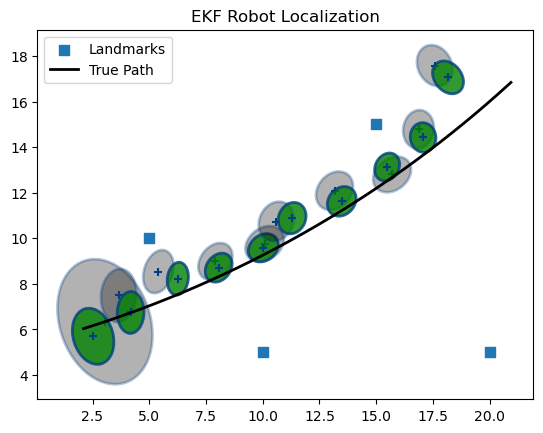

Final P: [0.01521635 0.01589162 0.00159918]


In [15]:
# Landmarks for simulation
landmarks = np.array([[5, 10], [10, 5], [15, 15], [20, 5]])

# Run the EKF with the defined landmarks
ekf = run_ekf_localization(landmarks, std_vel=0.1, std_steer=np.radians(1), std_range=0.3, std_bearing=0.1)
print('Final P:', ekf.P.diagonal())